# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [ ]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.stats.api as sms

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [ ]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
display(df.head())

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [ ]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [ ]:
# Convert categorical features to category type
categorical_cols = ['market_id', 'store_primary_category', 'order_protocol']
for col in categorical_cols:
    df[col] = df[col].astype('category')

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [ ]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [ ]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_day_of_week'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
# Drop unnecessary columns
df = df.drop(['created_at', 'actual_delivery_time', 'order_day_of_week'], axis=1)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [ ]:
# Define target variable (y) and features (X)
y = df['time_taken']
X = df.drop('time_taken', axis=1)

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include='category').columns

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

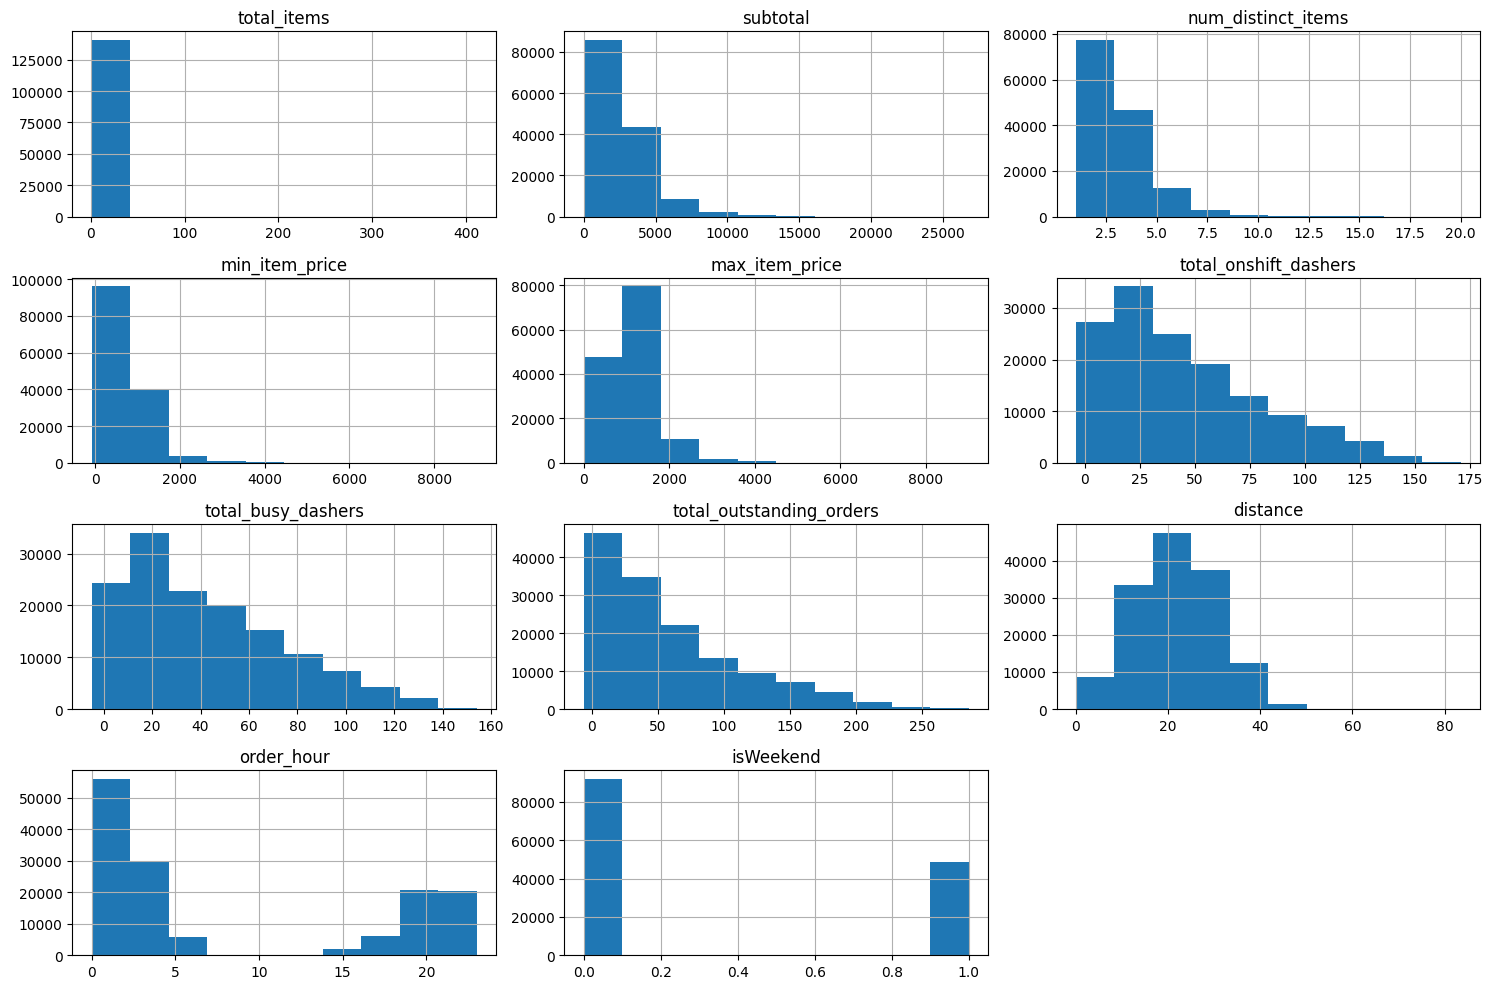

In [ ]:
# Plot distributions for all numerical columns
X_train[numerical_cols].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns
for col in categorical_cols:
    display(X_train[col].value_counts())

market_id
2.0    42722
4.0    36961
1.0    29662
3.0    16934
5.0    13838
6.0      504
Name: count, dtype: int64

store_primary_category
4     14483
55    12603
46    12427
13     7907
58     7227
      ...  
1         7
43        6
3         1
8         1
21        0
Name: count, Length: 73, dtype: int64

order_protocol
1.0    38746
3.0    37674
5.0    33118
2.0    16689
4.0    13842
6.0      534
7.0       18
Name: count, dtype: int64

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

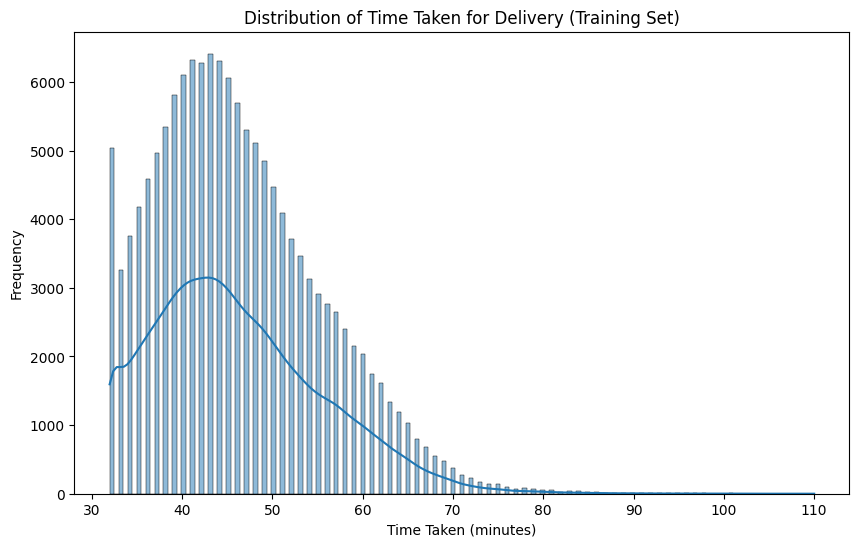

In [ ]:
# Distribution of time_taken
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True)
plt.title('Distribution of Time Taken for Delivery (Training Set)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

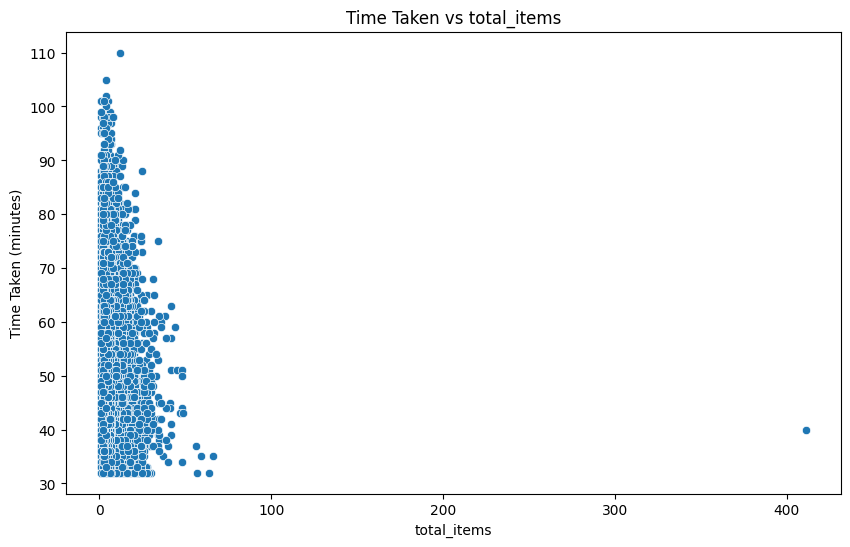

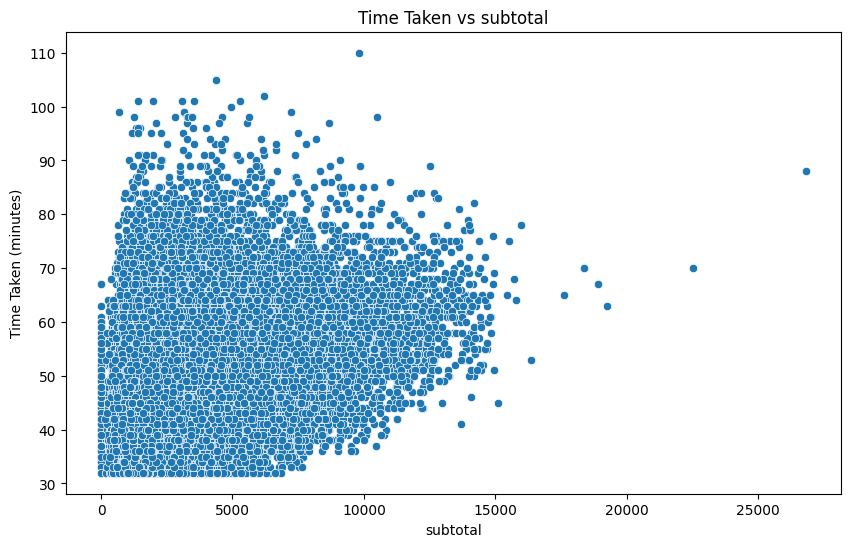

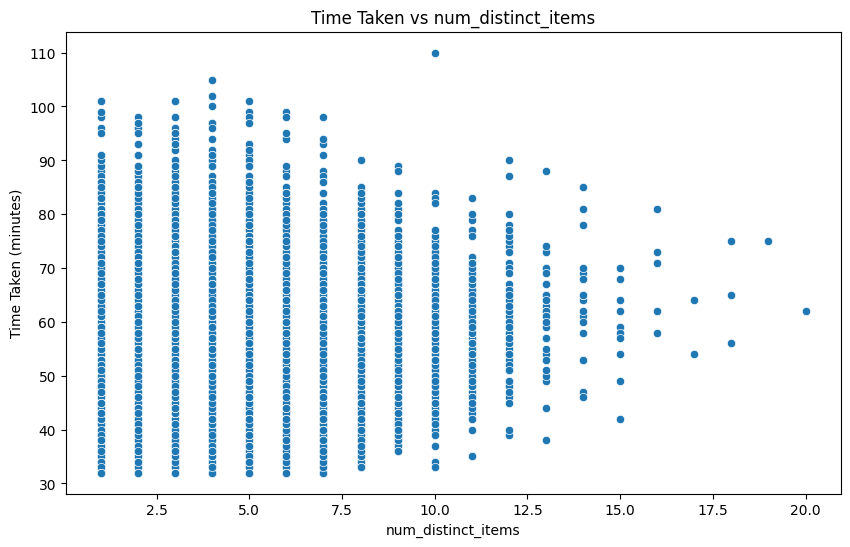

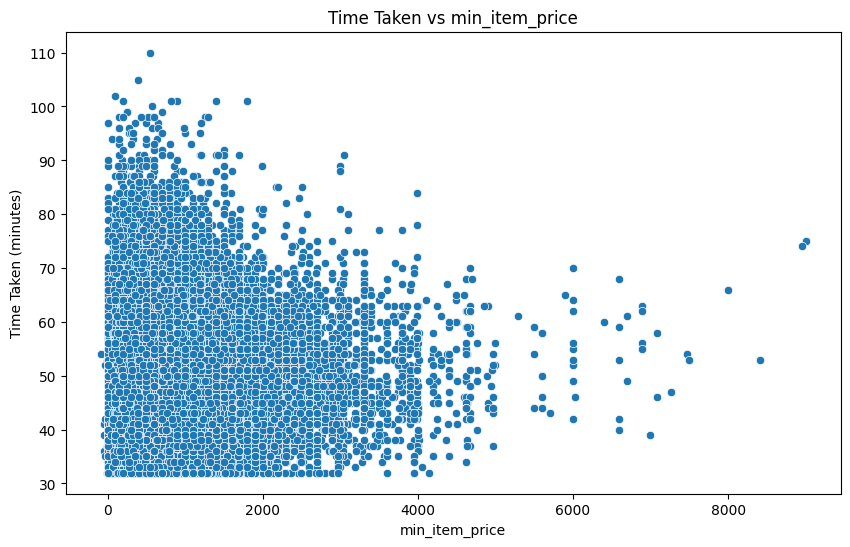

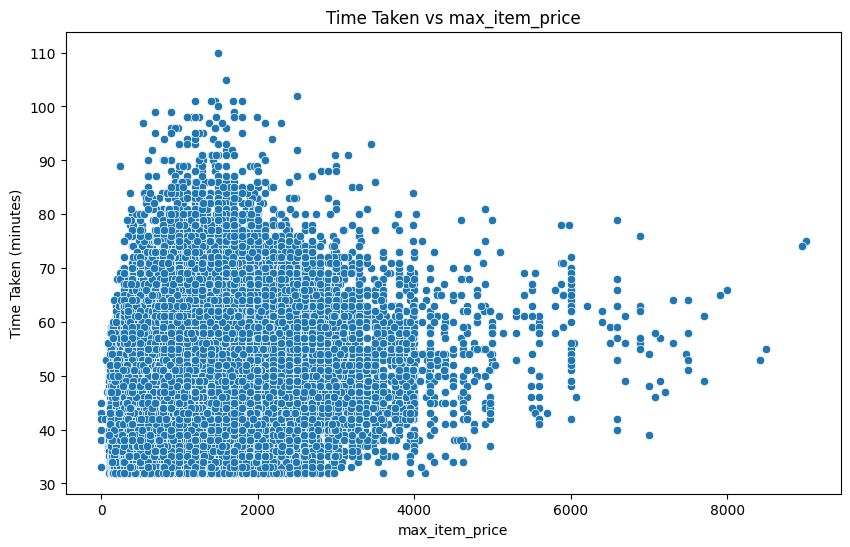

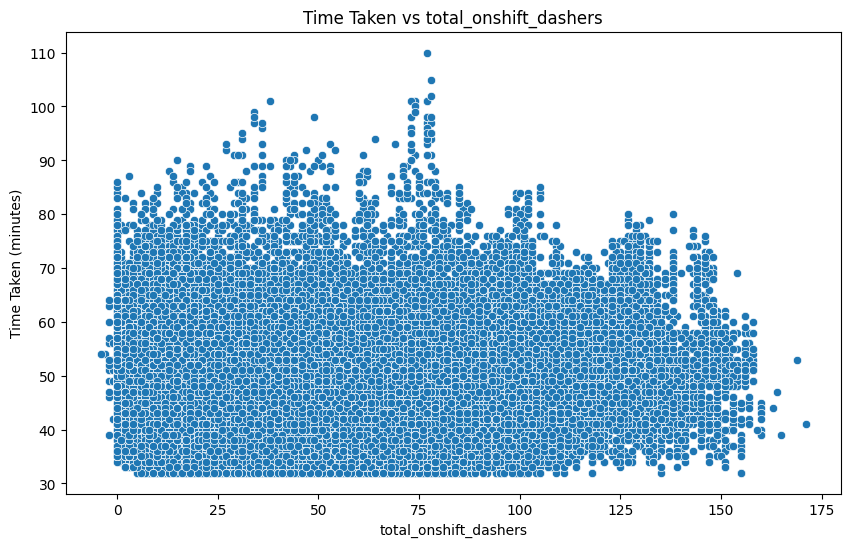

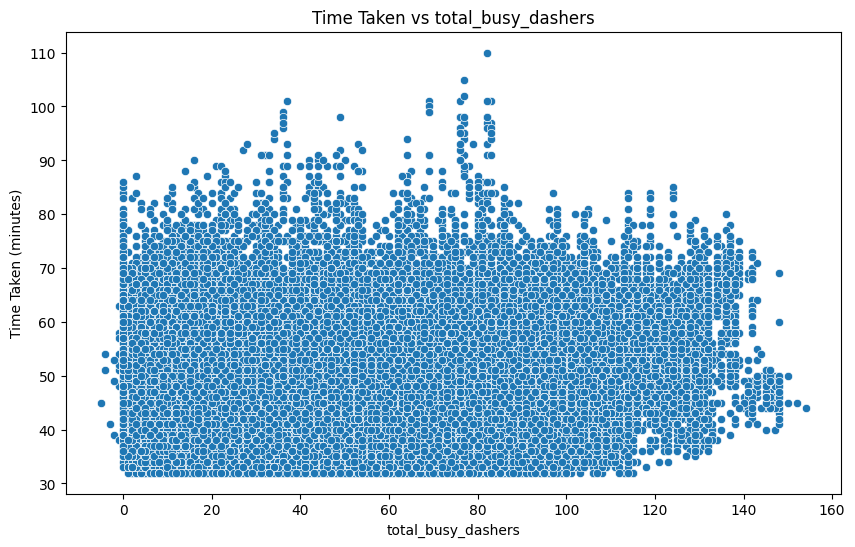

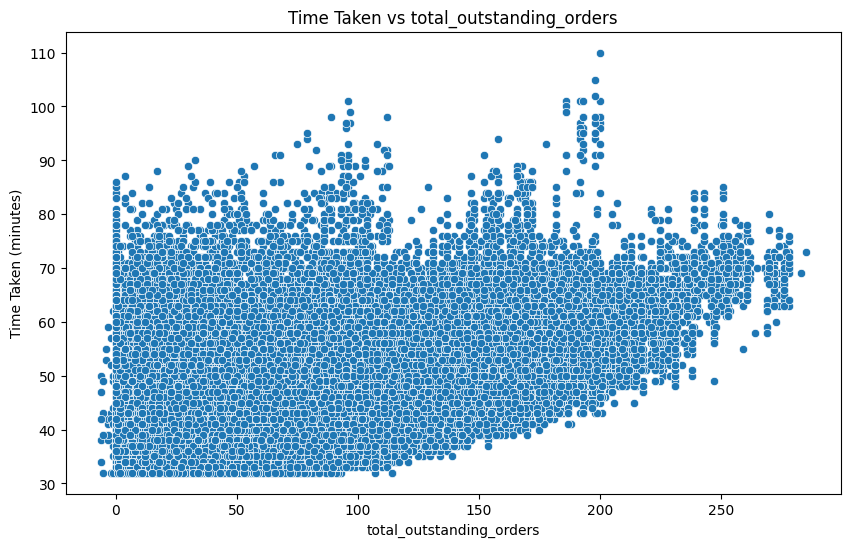

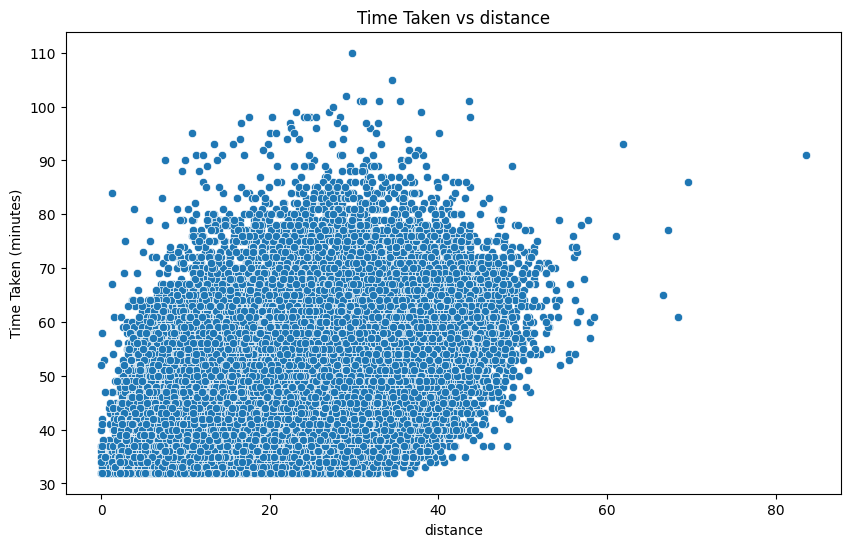

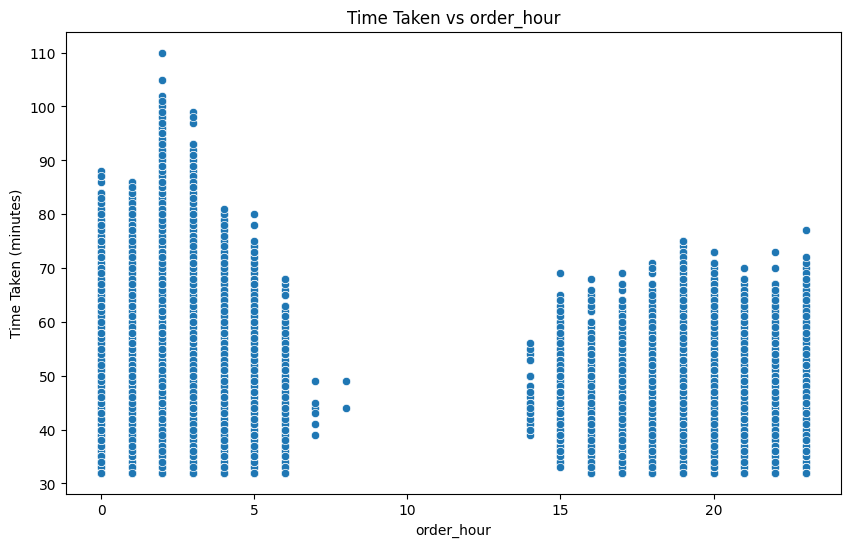

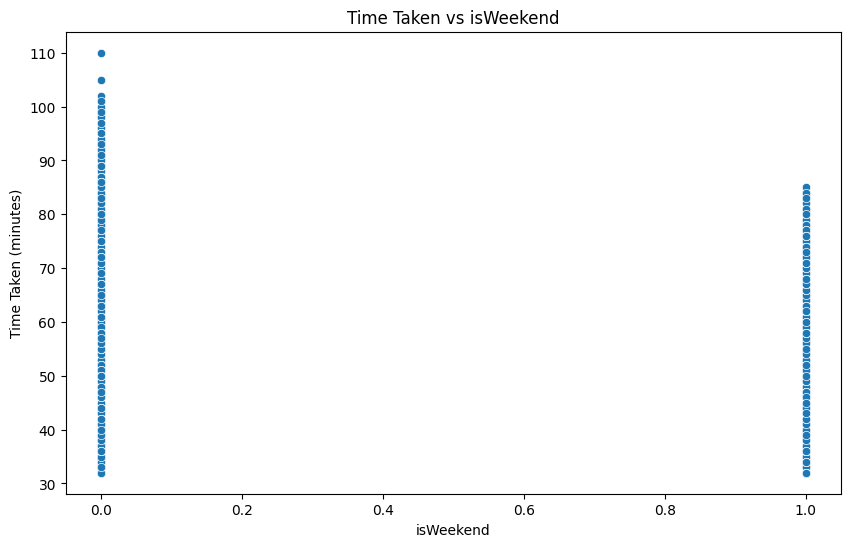

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_train[col], y=y_train)
    plt.title(f'Time Taken vs {col}')
    plt.xlabel(col)
    plt.ylabel('Time Taken (minutes)')
    plt.show()

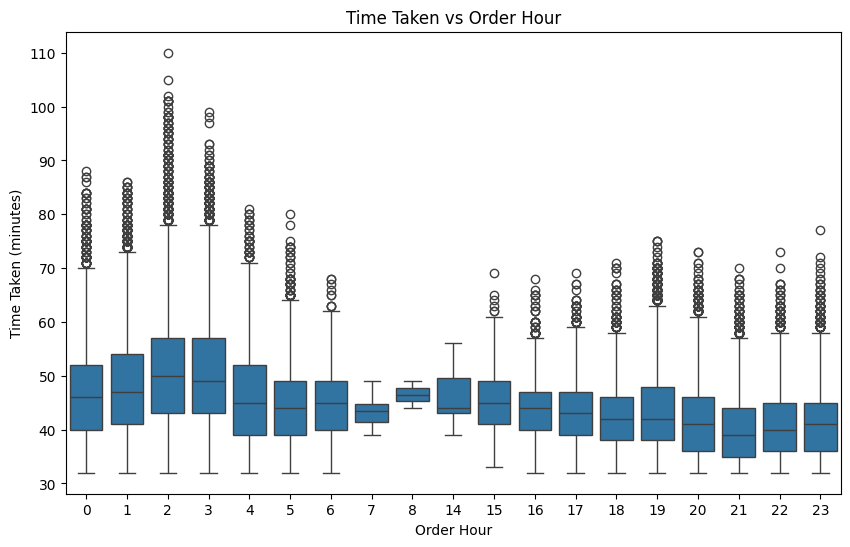

In [ ]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(10, 6))
sns.boxplot(x=X_train['order_hour'], y=y_train)
plt.title('Time Taken vs Order Hour')
plt.xlabel('Order Hour')
plt.ylabel('Time Taken (minutes)')
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

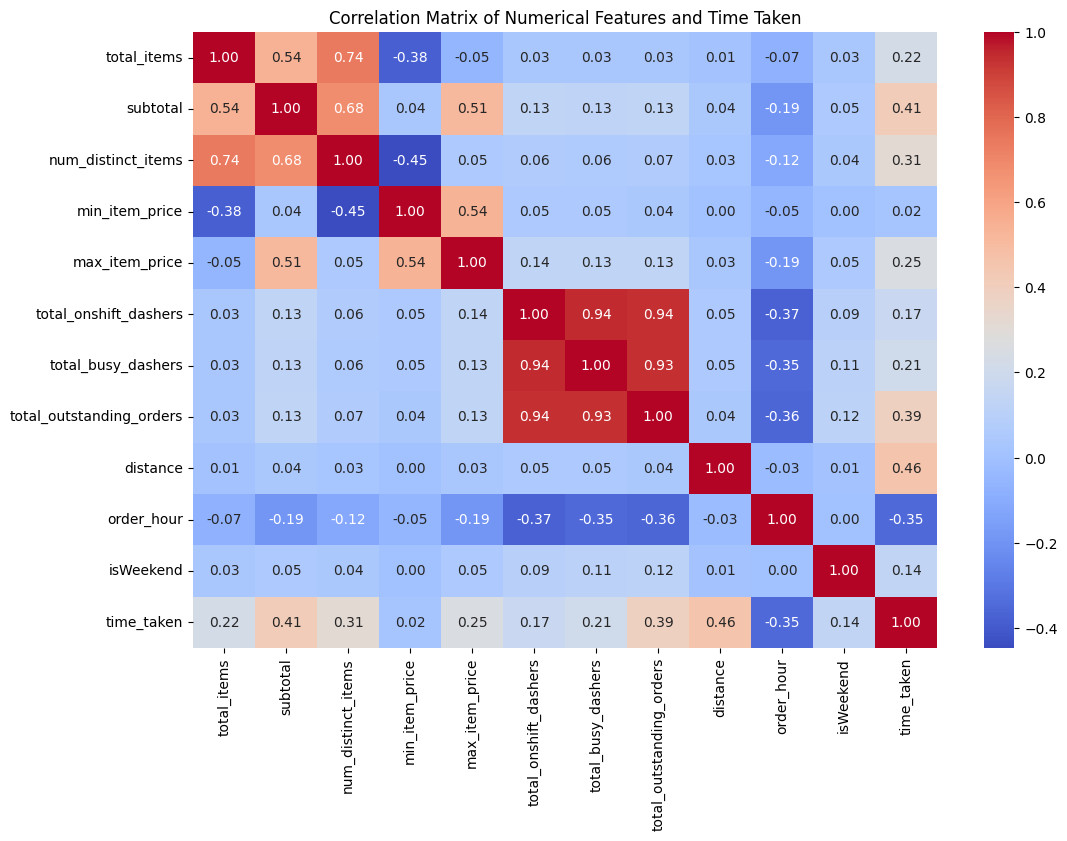

In [ ]:
# Calculate the correlation matrix
correlation_matrix = X_train[numerical_cols].copy()
correlation_matrix['time_taken'] = y_train.copy()
correlation_matrix = correlation_matrix.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Time Taken')
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [ ]:
# Drop 3-5 weakly correlated columns from training dataset
weak_corr_cols = ['min_item_price', 'total_items', 'isWeekend'] # Based on heatmap, these have relatively weak correlations
X_train = X_train.drop(weak_corr_cols, axis=1)

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

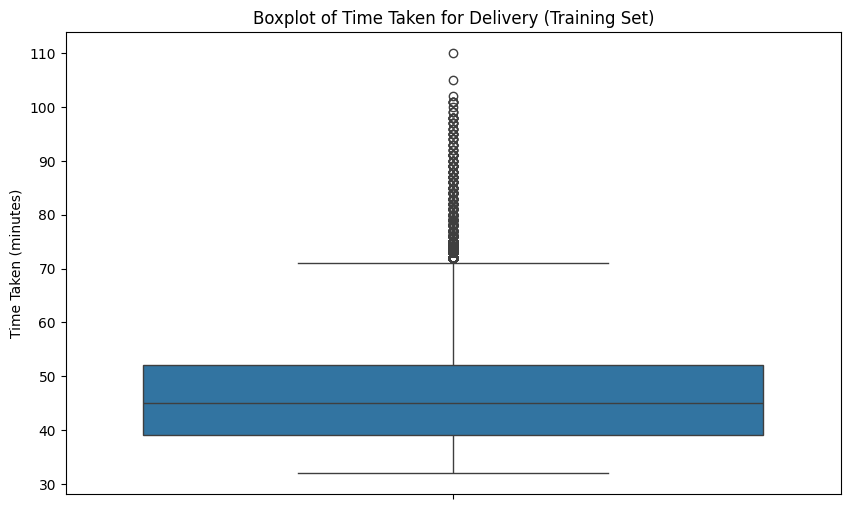

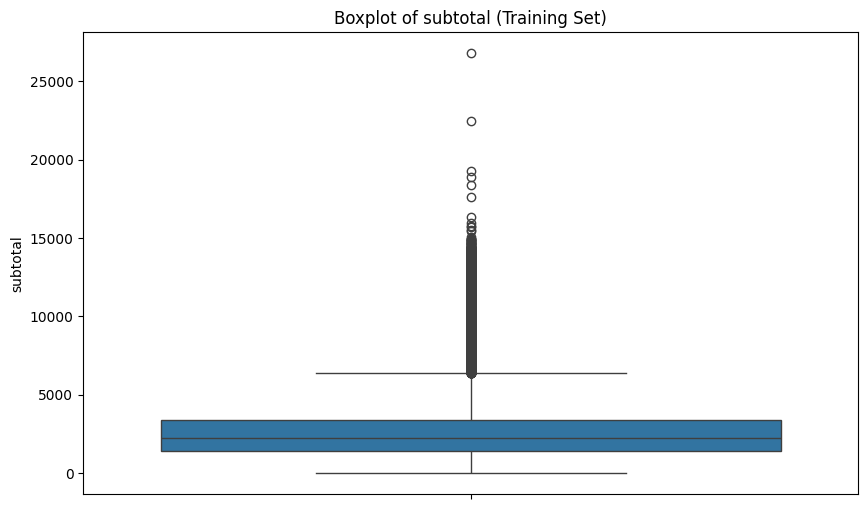

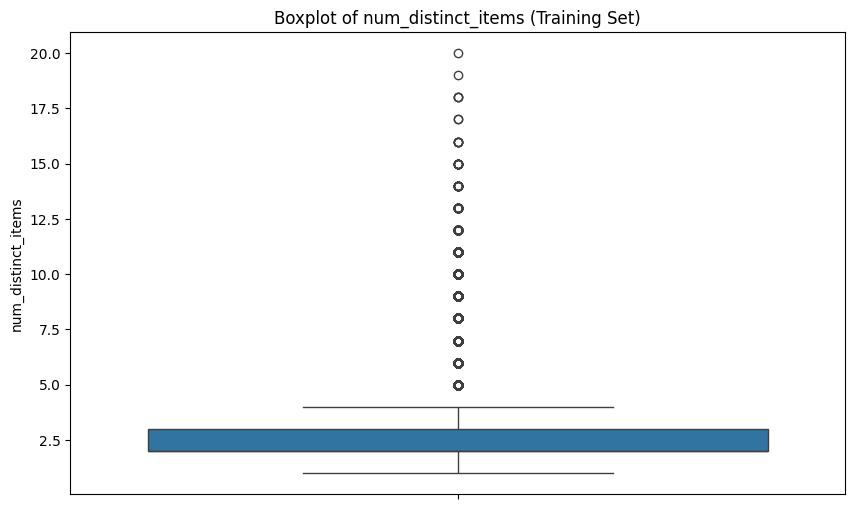

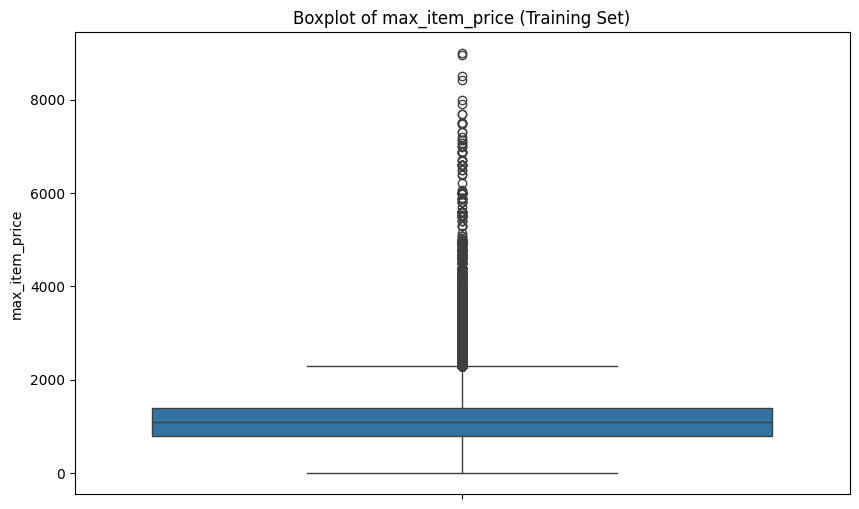

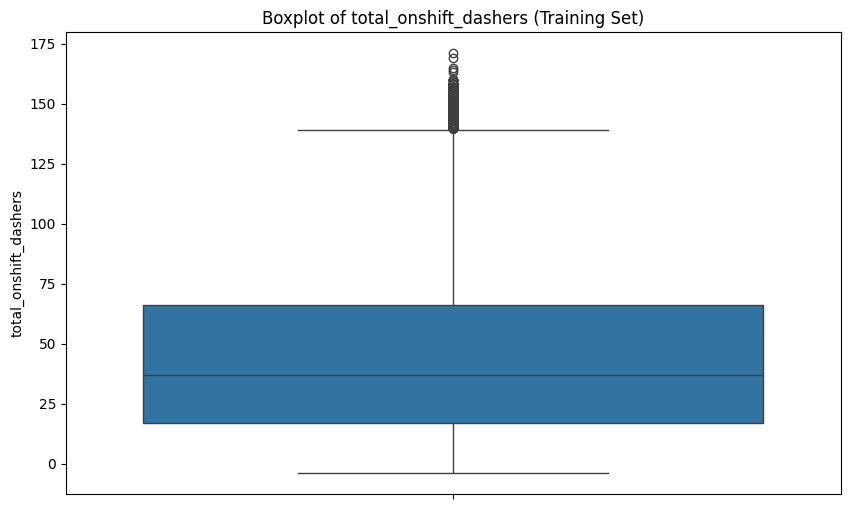

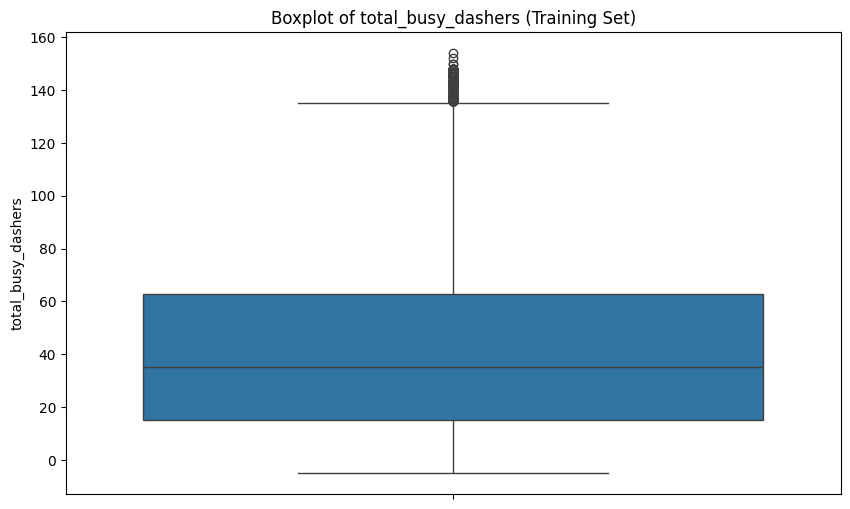

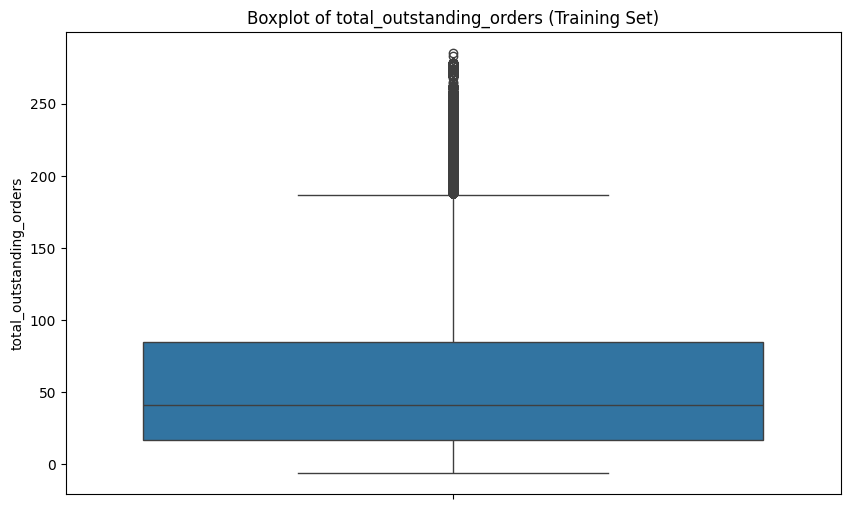

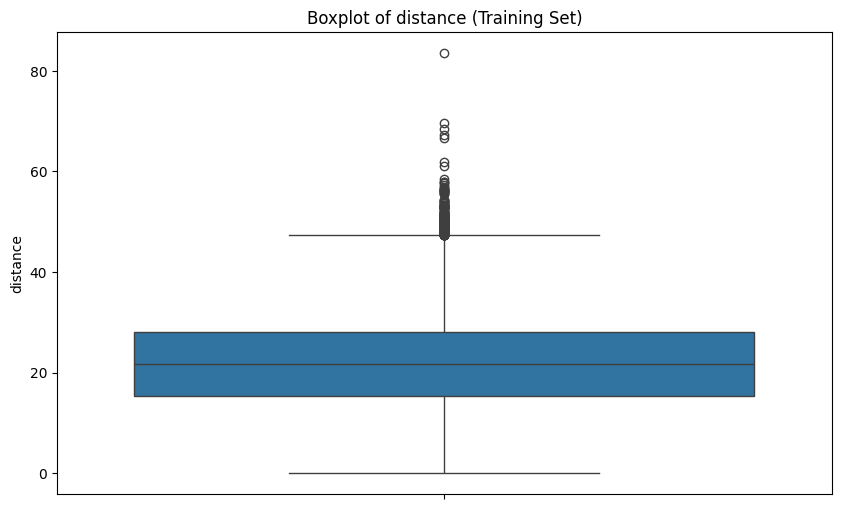

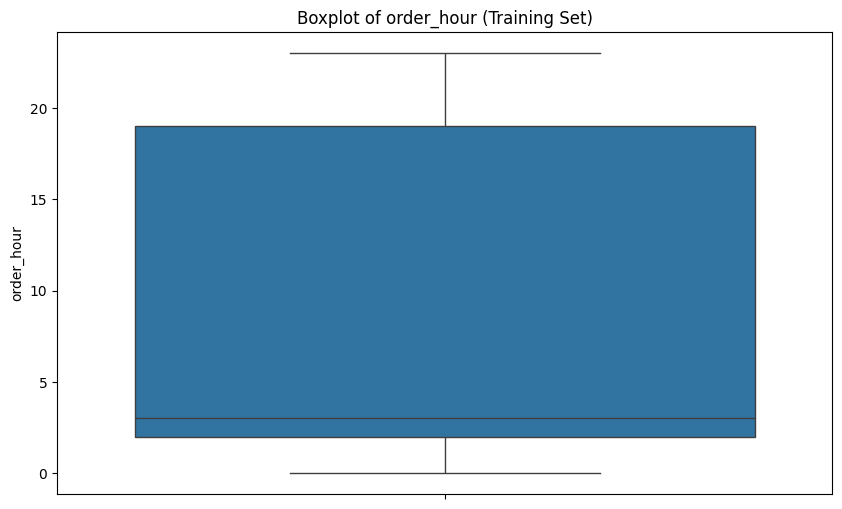

In [ ]:
# Boxplot for time_taken
plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train)
plt.title('Boxplot of Time Taken for Delivery (Training Set)')
plt.ylabel('Time Taken (minutes)')
plt.show()

# Update numerical_cols to reflect the current columns in X_train
numerical_cols = X_train.select_dtypes(include=np.number).columns

# Boxplots for numerical features
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=X_train[col])
    plt.title(f'Boxplot of {col} (Training Set)')
    plt.ylabel(col)
    plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [ ]:
# Handle outliers using the IQR method

# Calculate IQR and bounds for numerical features
Q1_X = X_train[numerical_cols].quantile(0.25)
Q3_X = X_train[numerical_cols].quantile(0.75)
IQR_X = Q3_X - Q1_X

lower_bound_X = Q1_X - 1.5 * IQR_X
upper_bound_X = Q3_X + 1.5 * IQR_X

# Calculate IQR and bounds for the target variable (time_taken)
Q1_y = y_train.quantile(0.25)
Q3_y = y_train.quantile(0.75)
IQR_y = Q3_y - Q1_y

lower_bound_y = Q1_y - 1.5 * IQR_y
upper_bound_y = Q3_y + 1.5 * IQR_y

# Create a boolean mask for outliers in numerical features
outlier_mask_X = (X_train[numerical_cols] >= lower_bound_X) & (X_train[numerical_cols] <= upper_bound_X)
# Ensure all numerical columns for a row are within bounds
outlier_mask_X = outlier_mask_X.all(axis=1)

# Create a boolean mask for outliers in the target variable
outlier_mask_y = (y_train >= lower_bound_y) & (y_train <= upper_bound_y)

# Combine the masks to keep only rows that are not outliers in any considered column or the target
non_outlier_mask = outlier_mask_X & outlier_mask_y

# Filter X_train and y_train to remove outliers
X_train = X_train[non_outlier_mask]
y_train = y_train[non_outlier_mask]

/tmp/ipython-input-21-4221291047.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[non_outlier_mask]


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols_test = X_test.select_dtypes(include=np.number).columns
categorical_cols_test = X_test.select_dtypes(include='category').columns

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

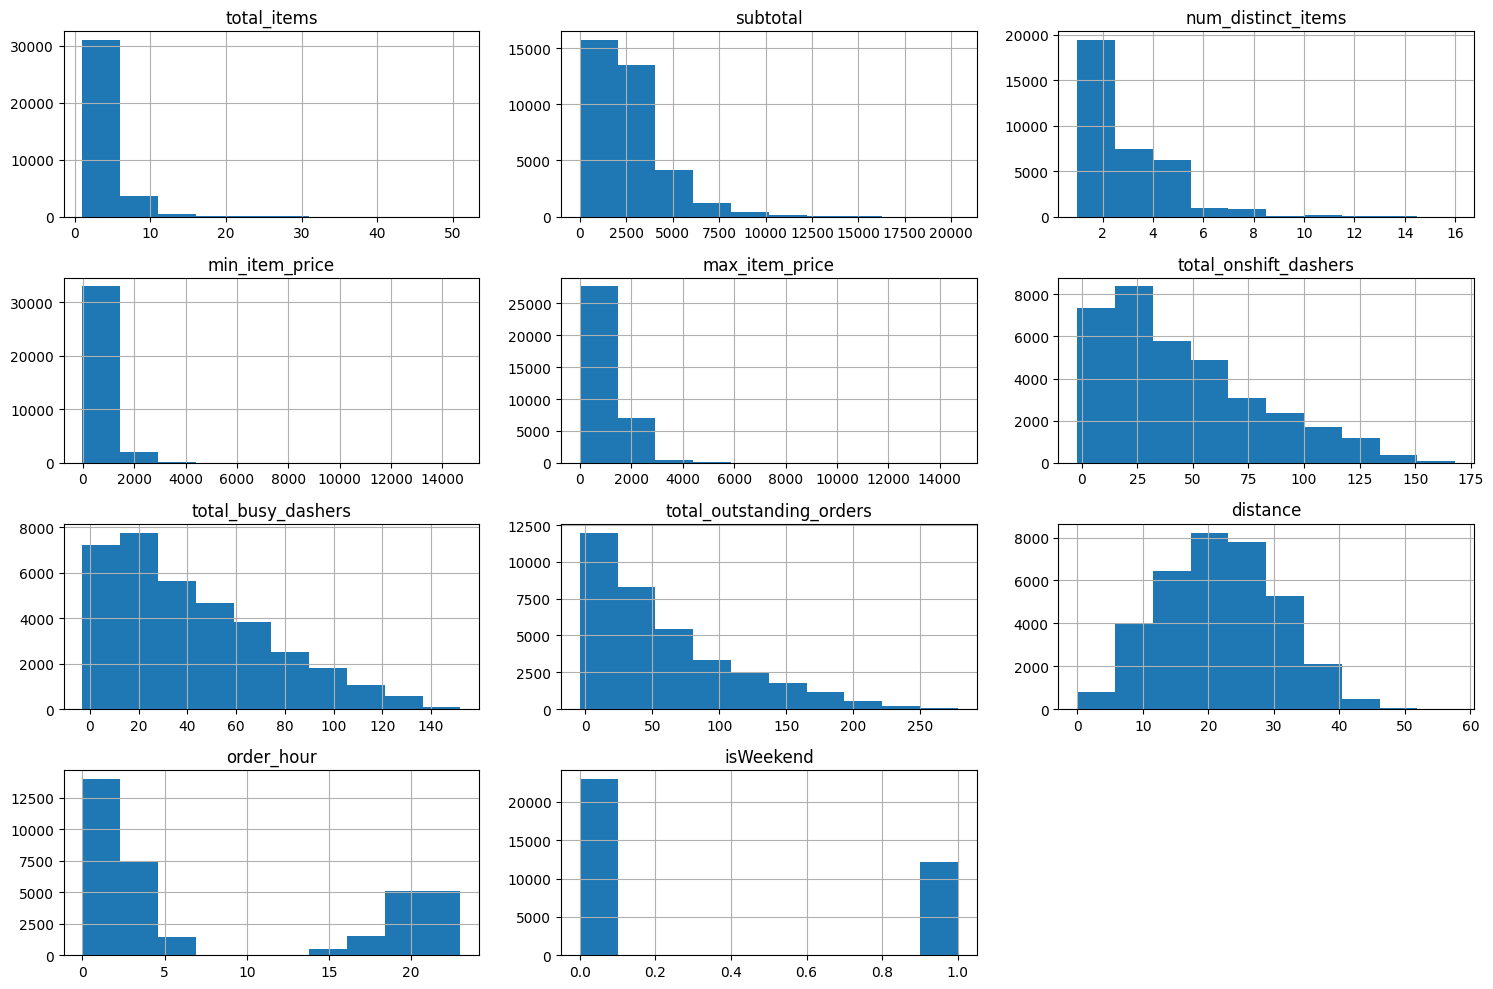

In [ ]:
# Plot distributions for all numerical columns
X_test[numerical_cols_test].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns
for col in categorical_cols_test:
    display(X_test[col].value_counts())

market_id
2.0    10747
4.0     9261
1.0     7453
3.0     4141
5.0     3420
6.0      134
Name: count, dtype: int64

store_primary_category
4     3700
46    3159
55    3142
13    2008
58    1768
      ... 
19       3
56       2
8        1
21       1
3        0
Name: count, Length: 73, dtype: int64

order_protocol
1.0    9658
3.0    9451
5.0    8297
2.0    4201
4.0    3404
6.0     144
7.0       1
Name: count, dtype: int64

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

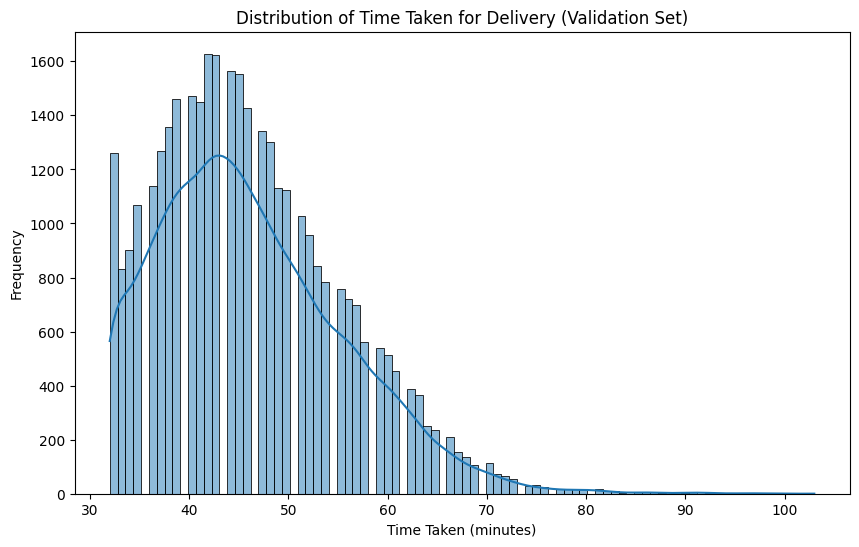

In [ ]:
# Distribution of time_taken
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True)
plt.title('Distribution of Time Taken for Delivery (Validation Set)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

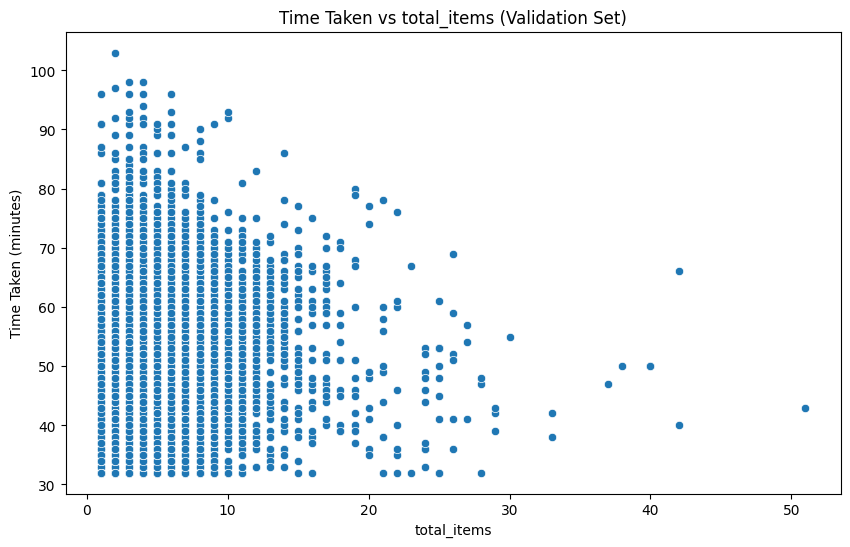

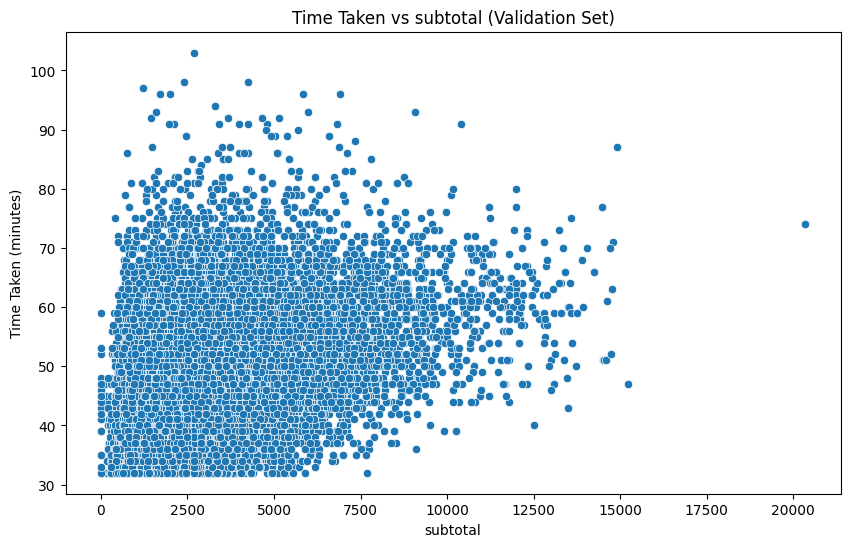

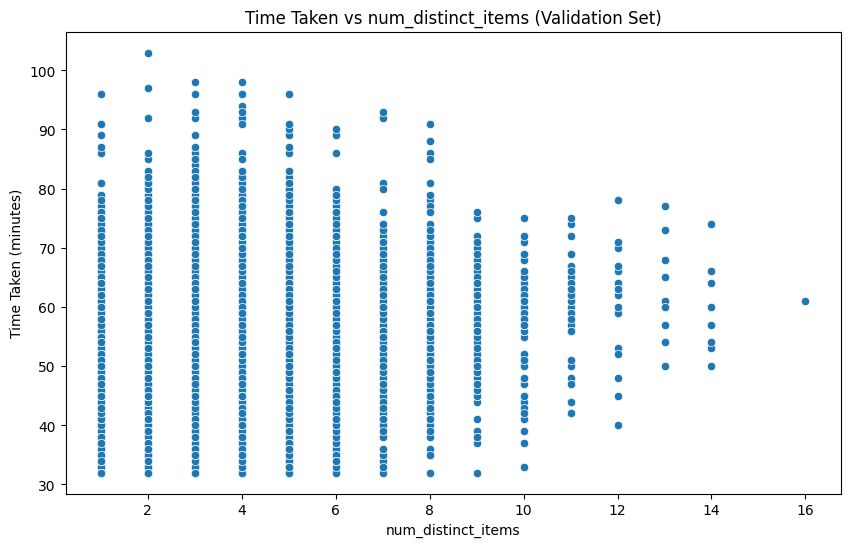

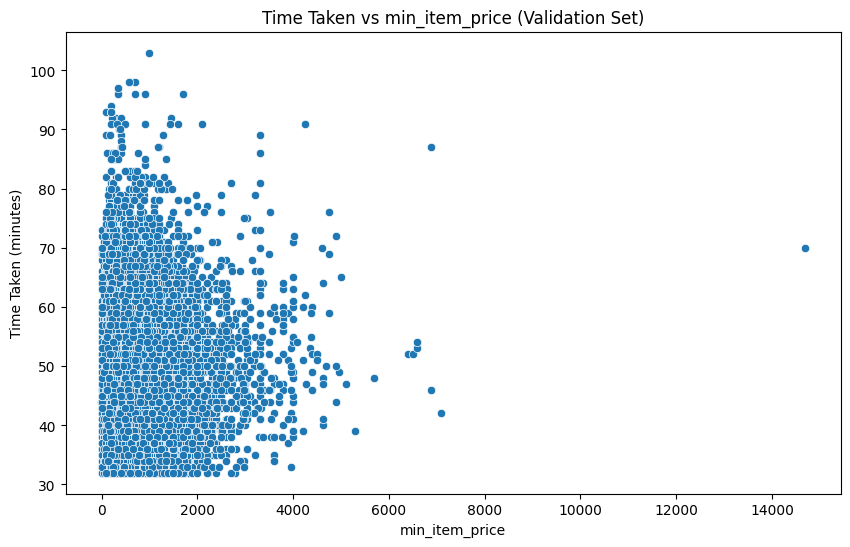

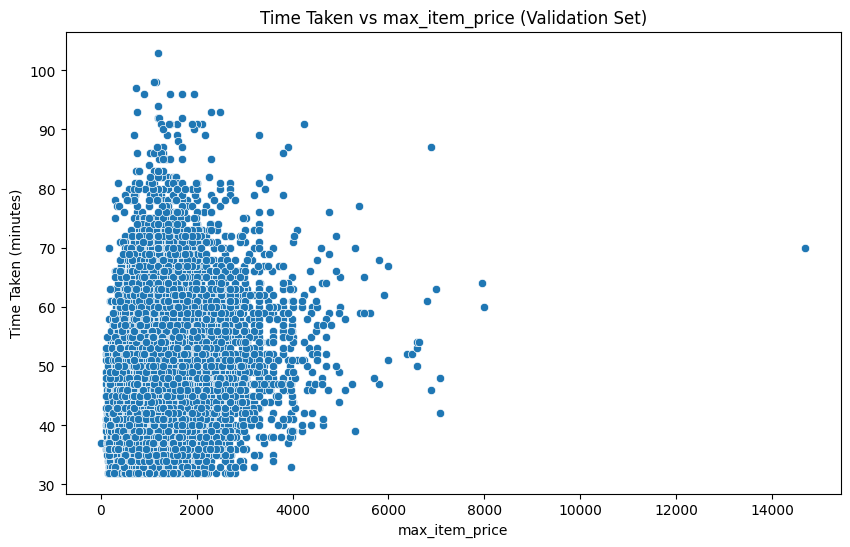

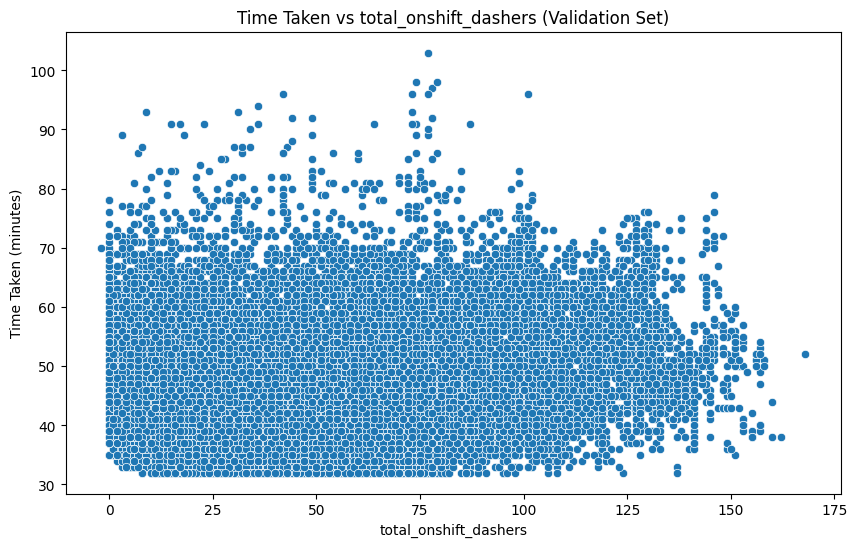

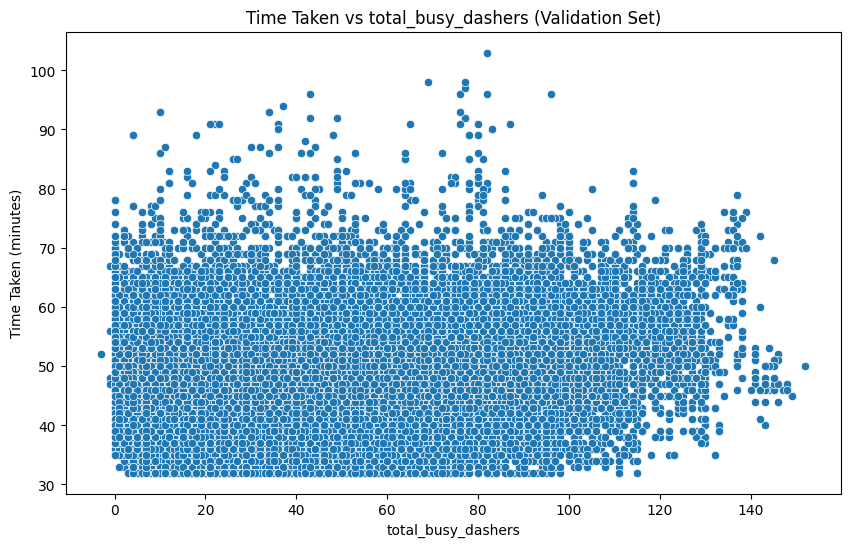

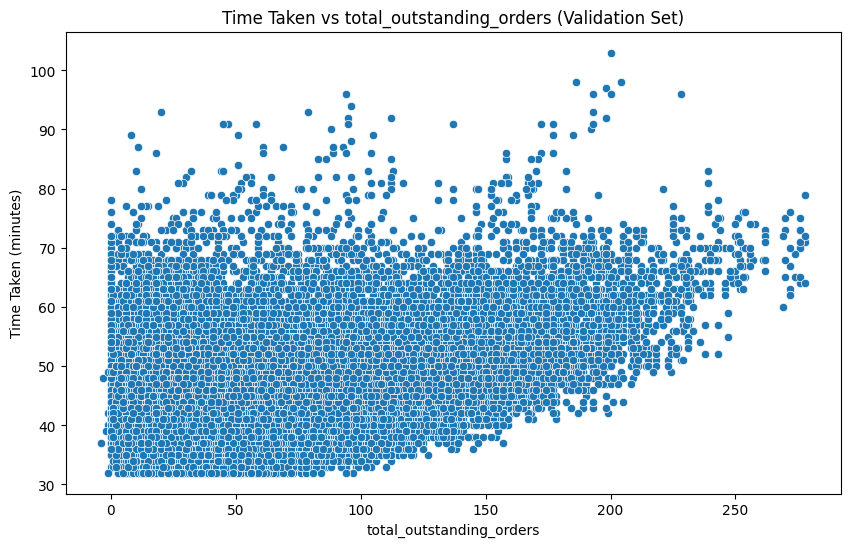

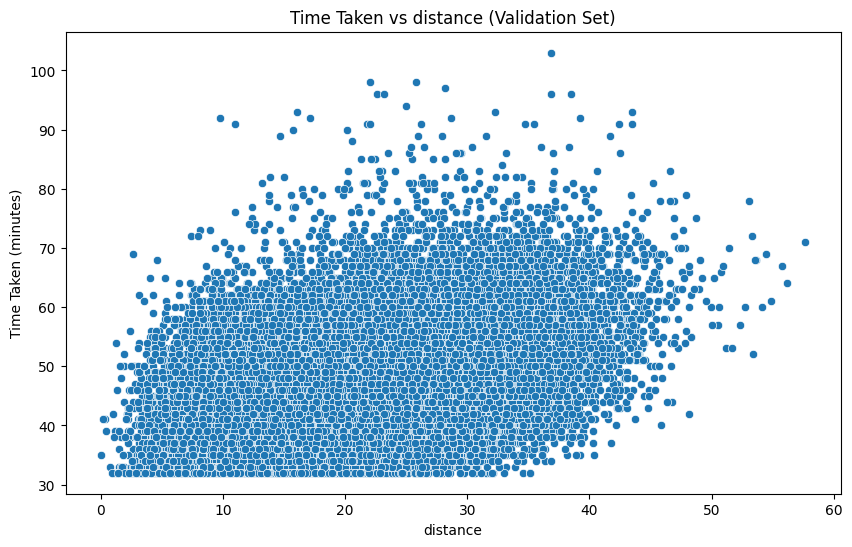

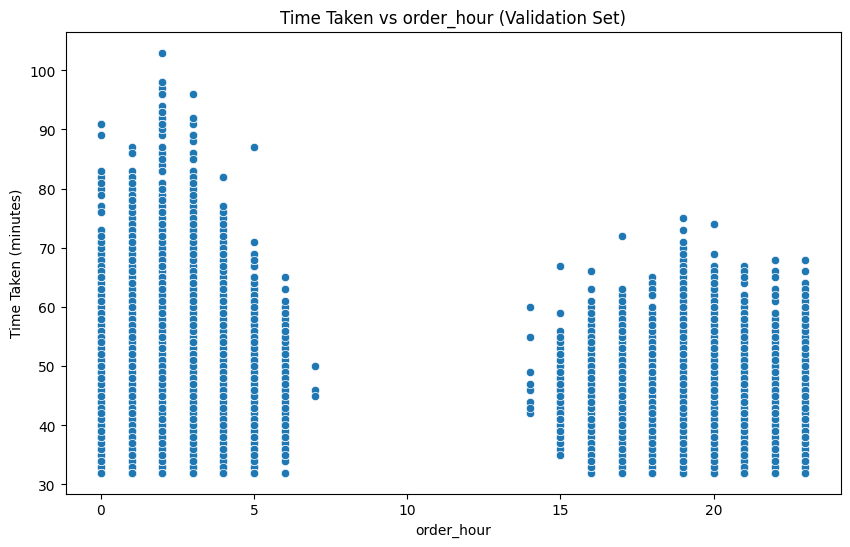

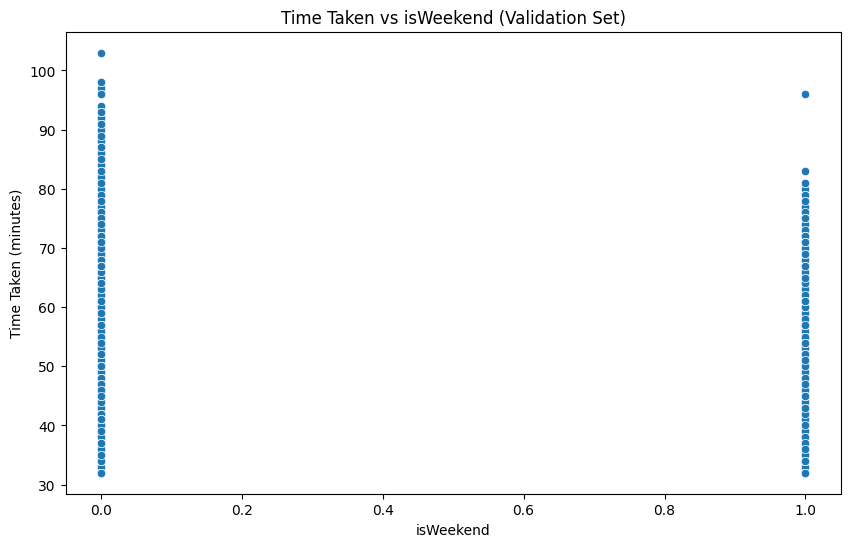

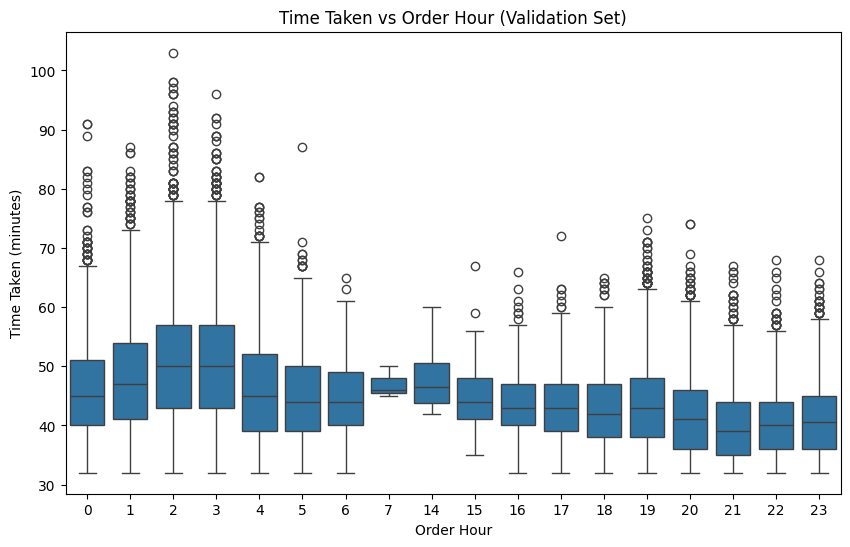

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in numerical_cols_test:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_test[col], y=y_test)
    plt.title(f'Time Taken vs {col} (Validation Set)')
    plt.xlabel(col)
    plt.ylabel('Time Taken (minutes)')
    plt.show()

# Show the distribution of time_taken for different hours in the validation set
plt.figure(figsize=(10, 6))
sns.boxplot(x=X_test['order_hour'], y=y_test)
plt.title('Time Taken vs Order Hour (Validation Set)')
plt.xlabel('Order Hour')
plt.ylabel('Time Taken (minutes)')
plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from test dataset
weak_corr_cols = ['min_item_price', 'total_items', 'isWeekend'] # Based on heatmap, these have relatively weak correlations
X_test = X_test.drop(weak_corr_cols, axis=1)

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [ ]:
# Import libraries

# The necessary libraries are already imported in the first code cell.
# import LinearRegression, StandardScaler, RFE, etc.

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [ ]:
# Apply scaling to the numerical columns
scaler = StandardScaler()

# Identify numerical columns in the training set after outlier removal
numerical_cols_train = X_train.select_dtypes(include=np.number).columns

X_train[numerical_cols_train] = scaler.fit_transform(X_train[numerical_cols_train])
X_test[numerical_cols_train] = scaler.transform(X_test[numerical_cols_train])

/tmp/ipython-input-28-1792875983.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_cols_train] = scaler.fit_transform(X_train[numerical_cols_train])


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [ ]:
# Create/Initialise the model
model = LinearRegression()

In [ ]:
# Train the model using the training data
model.fit(X_train[numerical_cols_train], y_train)

LinearRegression()

In [ ]:
# Make predictions
y_pred = model.predict(X_test[numerical_cols_train])

In [ ]:
# Find results for evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean Squared Error: 12.57
R-squared: 0.86


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [ ]:
# Loop through the number of features and test the model
results = []
num_features_range = range(1, len(numerical_cols_train) + 1)

for n_features in num_features_range:
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=n_features)
    rfe = rfe.fit(X_train[numerical_cols_train], y_train)

    X_train_rfe = X_train[numerical_cols_train].loc[:, rfe.support_]
    X_test_rfe = X_test[numerical_cols_train].loc[:, rfe.support_]

    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({'num_features': n_features, 'mse': mse, 'r2': r2})

results_df = pd.DataFrame(results)
display(results_df)

num_features        mse        r2
0             1  79.774637  0.088574
1             2  51.313963  0.413738
2             3  32.913199  0.623966
3             4  30.501564  0.651519
4             5  23.936072  0.726530
5             6  12.924229  0.852341
6             7  12.747050  0.854365
7             8  12.574527  0.856336

In [ ]:
# Build the final model with selected number of features
# Based on the RFE results, choose an optimal number of features (e.g., where R2 plateaus)
optimal_num_features = results_df.sort_values(by='r2', ascending=False).iloc[0]['num_features'] # Example: selecting based on highest R2

model = LinearRegression()
rfe = RFE(model, n_features_to_select=int(optimal_num_features))
rfe = rfe.fit(X_train[numerical_cols_train], y_train)

X_train_final = X_train[numerical_cols_train].loc[:, rfe.support_]
X_test_final = X_test[numerical_cols_train].loc[:, rfe.support_]

model.fit(X_train_final, y_train)
y_pred_final = model.predict(X_test_final)

mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, r2_final) #FIXME: calculate R2 using y_test and y_pred_final

print(f'Final Model with {int(optimal_num_features)} Features:')
print(f'Mean Squared Error: {mse_final:.2f}')
print(f'R-squared: {r2_final:.2f}')

# Display the selected features
print("\nSelected Features:")
display(X_train_final.columns)

Final Model with 8 Features:
Mean Squared Error: 12.57
R-squared: 0.86

Selected Features:


Index(['subtotal', 'num_distinct_items', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'order_hour'],
      dtype='object')

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

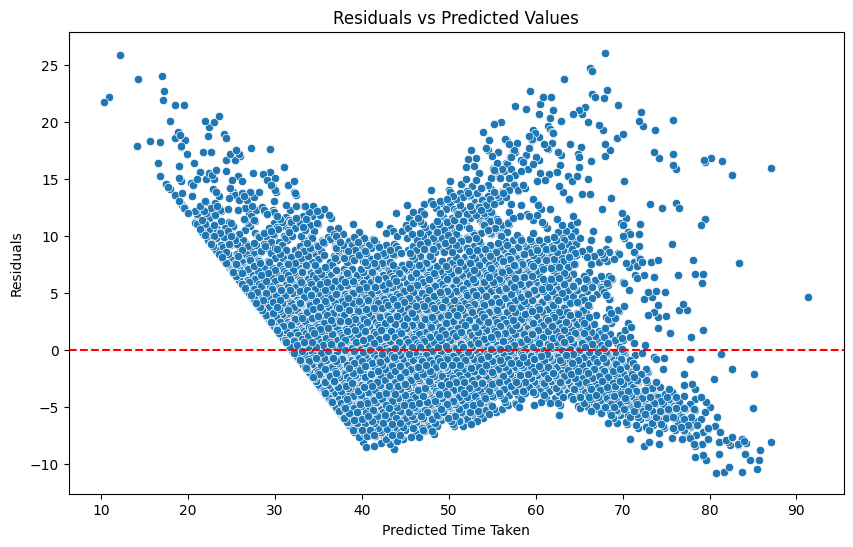

<Figure size 1000x600 with 0 Axes>

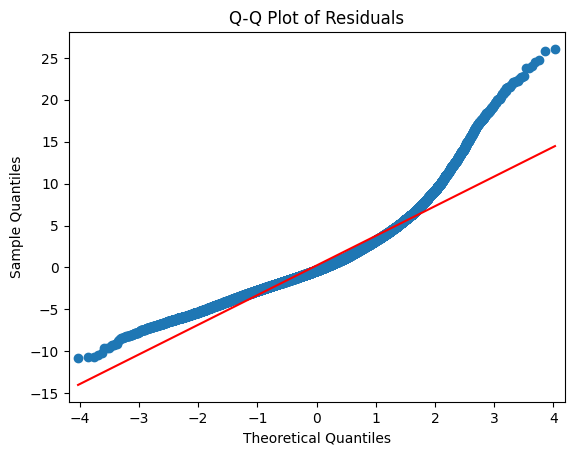

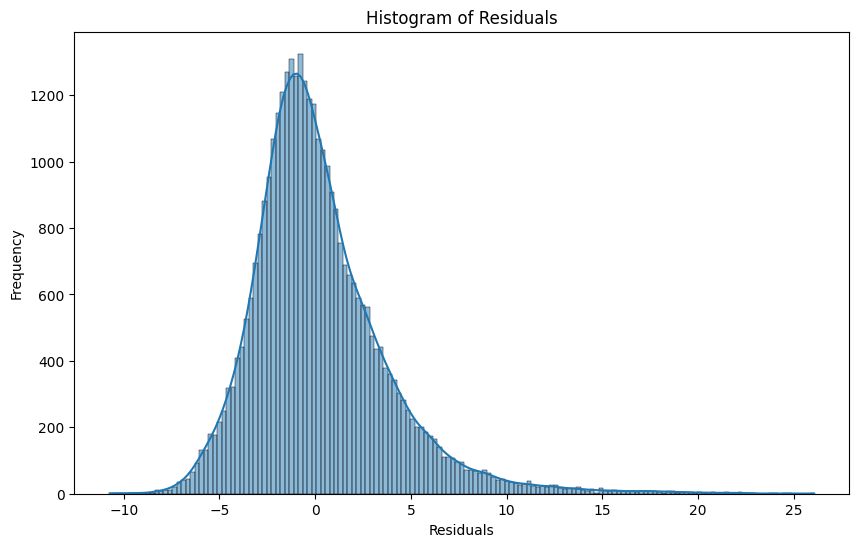

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
residuals = y_test - y_pred_final

# Residuals vs Predicted Values Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_final, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Time Taken')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

[Your inferences here:]
Residuals vs Predicted Values Plot: This plot shows the residuals on the y-axis and the predicted values on the x-axis. Ideally, the residuals should be randomly scattered around zero, with no discernible pattern. A pattern (like a cone shape or a curve) would suggest heteroscedasticity (non-constant variance of errors) or non-linearity in the relationship between the features and the target.
Q-Q Plot of Residuals: This plot compares the distribution of the residuals to a theoretical normal distribution. If the residuals are normally distributed, the points should fall along the straight line. Deviations from the line, especially at the tails, indicate departures from normality.
Histogram of Residuals: This histogram shows the distribution of the residuals. For a good linear regression model, the residuals should be approximately normally distributed around zero.



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model

# Get the coefficients of the scaled model
scaled_coefficients = pd.Series(model.coef_, index=X_train_final.columns)
print("Scaled Coefficients:")
display(scaled_coefficients)

# To get unscaled coefficients, we can use the scaler's inverse_transform
# However, this is not straightforward for individual coefficients.
# Instead, we can train a new model on the unscaled final features

# Get the unscaled training data for the final features
X_train_unscaled_final = X_train[numerical_cols_train].loc[:, rfe.support_]
# This will be the same as X_train_final before scaling

# Train a new model on the unscaled data
model_unscaled = LinearRegression()
model_unscaled.fit(X_train_unscaled_final, y_train)

# Get the unscaled coefficients
unscaled_coefficients = pd.Series(model_unscaled.coef_, index=X_train_unscaled_final.columns)
print("\nUnscaled Coefficients:")
display(unscaled_coefficients)

# Note: The intercept is on the unscaled scale by default in scikit-learn
print(f"\nScaled Model Intercept: {model.intercept_:.2f}")
print(f"Unscaled Model Intercept: {model_unscaled.intercept_:.2f}")

Scaled Coefficients:


subtotal                     1.352877
num_distinct_items           0.464384
max_item_price               0.353553
total_onshift_dashers      -11.361396
total_busy_dashers          -3.418869
total_outstanding_orders    14.538767
distance                     4.014928
order_hour                  -2.044974
dtype: float64


Unscaled Coefficients:


subtotal                     1.352877
num_distinct_items           0.464384
max_item_price               0.353553
total_onshift_dashers      -11.361396
total_busy_dashers          -3.418869
total_outstanding_orders    14.538767
distance                     4.014928
order_hour                  -2.044974
dtype: float64


Scaled Model Intercept: 43.81
Unscaled Model Intercept: 43.81


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature.
# The unscaled coefficients directly indicate the change in the target variable for a one-unit increase in the corresponding feature, holding other features constant.
# For example, based on the unscaled coefficients, a one-unit increase in 'distance' is associated with a 'unscaled_coefficients['distance']' minute increase in 'time_taken', assuming all other features remain constant.
# Similarly, a one-unit increase in 'total_outstanding_orders' is associated with a 'unscaled_coefficients['total_outstanding_orders']' minute increase in 'time_taken'.
# The scaled coefficients show the change in the target variable for a one standard deviation increase in the corresponding feature. This is useful for comparing the relative impact of features that are on different scales.

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, there are categorical variables in the data: `market_id`, `store_primary_category`, and `order_protocol`.

From the analysis of the categorical variables:
- `market_id`: The `value_counts()` show that markets 2, 4, and 1 have the highest number of orders. This suggests that delivery times might vary across different markets due to factors like geographical location, infrastructure, or local demand.
- `store_primary_category`: There is a wide variety of store primary categories, with some categories having significantly more orders than others (e.g., 4, 55, 46). Different store categories might have different preparation times, order complexities, or locations, which could influence delivery time.
- `order_protocol`: The `value_counts()` indicate that order protocols 1, 3, and 5 are the most frequent. Different order protocols could imply different order processing workflows or communication methods, potentially affecting how quickly an order is ready for pickup and delivery.

While the `value_counts()` give us the distribution of these categories, further analysis like visualizing the relationship between these categorical features and `time_taken` (e.g., using boxplots as done for `order_hour`) would provide more direct insights into their effect on delivery time. However, the distribution of orders across these categories suggests that they are important factors to consider in a delivery time prediction model.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>`test_size = 0.2` refers to the proportion of the dataset that will be allocated to the test set during the data splitting process. In this case, 20% of the data is used for testing the model, and the remaining 80% is used for training the model.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>Looking at the heatmap, the numerical feature with the highest absolute correlation with the target variable `time_taken` is `distance` (0.46). `subtotal` (0.41) and `total_outstanding_orders` (0.39) also show relatively strong positive correlations. `order_hour` (-0.35) has a notable negative correlation.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>My approach to detect outliers was primarily through visualization using boxplots. Boxplots for `time_taken` and the numerical features in the training set were generated to visually identify data points that fall significantly outside the typical range (indicated by the whiskers of the box).

To address the outliers, I used the Interquartile Range (IQR) method. For each numerical feature and the target variable (`time_taken`), I calculated the first quartile (Q1) and the third quartile (Q3). The IQR is the difference between Q3 and Q1. Outliers were defined as data points falling below `Q1 - 1.5 * IQR` or above `Q3 + 1.5 * IQR`. I then created a boolean mask to identify rows where *any* of the numerical features or the target variable were considered outliers based on this criterion. Finally, I filtered both the training features (`X_train`) and the training target variable (`y_train`) to remove these identified outlier rows, ensuring that the filtered datasets remained aligned.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>
1.  **total_outstanding_orders:** This feature has the largest positive unscaled coefficient (14.54), indicating that an increase in the number of outstanding orders is associated with a significant increase in delivery time.
2.  **total_onshift_dashers:** This feature has the largest negative unscaled coefficient (-11.36), suggesting that an increase in the number of on-shift dashers is associated with a significant decrease in delivery time.
3.  **distance:** This feature has a positive unscaled coefficient (4.01), indicating that a longer distance to the customer is associated with an increase in delivery time.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>
Linear Regression is a supervised learning algorithm used for predicting a continuous target variable based on one or more input features. The goal of linear regression is to find a linear relationship between the input features (independent variables) and the target variable (dependent variable) that best fits the data.

The fundamental idea is to model the relationship as a straight line (or a hyperplane in the case of multiple features). The equation of a simple linear regression model with one feature ($x$) and a target variable ($y$) is:

$y = \beta_0 + \beta_1x + \epsilon$

Where:
- $y$ is the dependent variable (the target we want to predict).
- $x$ is the independent variable (the input feature).
- $\beta_0$ is the y-intercept (the value of $y$ when $x$ is 0).
- $\beta_1$ is the slope of the line (the change in $y$ for a one-unit change in $x$).
- $\epsilon$ is the error term (the irreducible error or noise).

In the case of multiple linear regression with multiple features ($x_1, x_2, ..., x_n$), the equation becomes:

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

The core task in linear regression is to find the optimal values for the coefficients ($\beta_0, \beta_1, ..., \beta_n$) that minimize the difference between the predicted values ($\hat{y}$) and the actual values ($y$). This difference is called the residual. The most common method to find these optimal coefficients is called **Ordinary Least Squares (OLS)**.

OLS works by minimizing the **Sum of Squared Residuals (SSR)**, also known as the **cost function** or **loss function**. The SSR is calculated as the sum of the squared differences between the actual $y$ values and the predicted $\hat{y}$ values for all data points:

$SSR = \sum_{i=1}^{m} (y_i - \hat{y}_i)^2$

Where:
- $m$ is the number of data points.
- $y_i$ is the actual value of the target variable for the $i$-th data point.
- $\hat{y}_i$ is the predicted value of the target variable for the $i$-th data point.

Minimizing the SSR involves finding the values of the coefficients that result in the smallest sum of these squared errors. This is typically done using mathematical techniques like calculus (finding the derivatives of the SSR with respect to each coefficient and setting them to zero) or iterative optimization algorithms like gradient descent.

Once the optimal coefficients are found, the linear regression model can be used to predict the target variable for new, unseen data points by plugging their feature values into the linear equation.

Key assumptions of linear regression include:
1.  **Linearity:** The relationship between the features and the target variable is linear.
2.  **Independence of Residuals:** The residuals are independent of each other.
3.  **Homoscedasticity:** The variance of the residuals is constant across all levels of the independent variables.
4.  **Normality of Residuals:** The residuals are normally distributed.
5.  **No Multicollinearity:** The independent variables are not highly correlated with each other (in multiple linear regression).

Violations of these assumptions can affect the reliability and interpretability of the linear regression model.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>The main difference between simple linear regression and multiple linear regression lies in the number of independent variables (features) used to predict the dependent variable (target).

-   **Simple Linear Regression:** Uses only **one** independent variable to predict the dependent variable. The relationship is modeled by a straight line: $y = \beta_0 + \beta_1x + \epsilon$.
-   **Multiple Linear Regression:** Uses **two or more** independent variables to predict the dependent variable. The relationship is modeled by a hyperplane: $y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$.

In essence, multiple linear regression extends simple linear regression to accommodate the influence of multiple factors on the target variable.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The **cost function** in linear regression quantifies the difference between the predicted values of the target variable and the actual values. Its role is to provide a measure of how well the linear model fits the data. A lower cost function value indicates a better fit.

The most common cost function used in linear regression is the **Mean Squared Error (MSE)** or the **Sum of Squared Residuals (SSR)**. MSE is simply the average of the squared residuals, while SSR is the sum of the squared residuals. Both represent the sum of the squared vertical distances between the actual data points and the predicted line (or hyperplane).

The cost function is minimized by finding the values of the model's coefficients (the intercept and the slopes for each feature) that result in the lowest possible cost. This minimization is typically achieved using optimization techniques, such as:

1.  **Ordinary Least Squares (OLS):** This is a closed-form solution that directly calculates the optimal coefficients by solving a set of linear equations derived from setting the derivatives of the cost function with respect to each coefficient to zero. This method is computationally efficient for smaller datasets but can become slow for very large datasets.
2.  **Gradient Descent:** This is an iterative optimization algorithm. It starts with initial values for the coefficients and then repeatedly adjusts them in the direction that decreases the cost function most steeply. This process continues until the algorithm converges to a minimum of the cost function. Gradient descent is particularly useful for large datasets where OLS is computationally expensive.

By minimizing the cost function, the linear regression algorithm finds the line (or hyperplane) that best captures the linear relationship between the features and the target variable in the training data.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>**Overfitting** occurs when a model learns the training data too well, including the noise and random fluctuations. This results in a model that performs exceptionally well on the training data but poorly on unseen or new data. An overfitted model is too complex and captures the specific patterns of the training set rather than the underlying general relationship.

**Underfitting** occurs when a model is too simple to capture the underlying patterns in the training data. This results in a model that performs poorly on both the training data and unseen data. An underfitted model fails to learn the relationships between the features and the target variable effectively.

Here's a simple analogy:

-   **Overfitting:** Like a student who memorizes answers for a specific test but doesn't understand the concepts. They'll do well on that test but fail on a test with slightly different questions.
-   **Underfitting:** Like a student who doesn't study at all. They won't do well on any test.

In the context of linear regression:

-   **Overfitting** might happen if you include too many features, especially irrelevant ones, or if you fit a very high-degree polynomial to the data. The model becomes too sensitive to the specific data points in the training set.
-   **Underfitting** might happen if you use too few features or if the true relationship between the features and the target is non-linear, but you force a linear model. The model is too simple to capture the complexity of the data.

The goal is to find a model that generalizes well to new data, striking a balance between underfitting and overfitting. This is often achieved through techniques like feature selection, regularization, and cross-validation.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots are essential diagnostic tools in linear regression analysis. Residuals are the differences between the observed values of the dependent variable and the values predicted by the model. Analyzing the patterns in residual plots helps to assess whether the assumptions of linear regression are met and to identify potential problems with the model.

Here's how residual plots help in diagnosing a linear regression model:

1.  **Checking for Linearity:** A plot of residuals versus predicted values (or versus each independent variable) should show a random scatter of points around zero. If there is a discernible pattern (e.g., a curve or a U-shape), it suggests that the relationship between the independent variables and the dependent variable is not linear, and a linear model may not be appropriate.

2.  **Checking for Homoscedasticity (Constant Variance):** Homoscedasticity assumes that the variance of the residuals is constant across all levels of the independent variables. In a residual vs. predicted values plot, if the spread of the residuals is roughly constant across the range of predicted values, the assumption is met. If the spread of residuals increases or decreases as the predicted values change (forming a cone shape), it indicates heteroscedasticity, which can lead to biased standard errors and unreliable hypothesis tests.

3.  **Checking for Independence of Residuals:** Residuals should be independent of each other. While residual plots don't directly test for independence, patterns in plots (like autocorrelation in time series data) can suggest violations. For cross-sectional data, a random scatter generally supports independence.

4.  **Checking for Normality of Residuals:** The Q-Q plot (Quantile-Quantile plot) of residuals compares the distribution of the residuals to a theoretical normal distribution. If the residuals are normally distributed, the points on the Q-Q plot should fall approximately along a straight line. Deviations from the line, especially in the tails, indicate departures from normality, which can affect the validity of statistical inferences. A histogram of residuals can also provide a visual check of the normality assumption; a bell-shaped distribution centered around zero suggests normality.

In summary, residual plots allow us to visually inspect the errors of the model and gain insights into whether the model's assumptions are valid and whether there are any systematic patterns in the errors that the linear model is not capturing. This helps in determining if the linear regression model is appropriate for the data and if any transformations or alternative modeling techniques are needed.